# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

## Time series analysis

Load the data from "Price of Weed".

In [2]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


The following function takes a DataFrame of transactions and compute daily averages.

## Exercises

**Exercise:**   The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of `RunLinearModel` that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

In [3]:
# Solution

def RunQuadraticModel(daily):
    """Runs a linear model of prices versus years.

    daily: DataFrame of daily prices

    returns: model, results
    """
    daily['years2'] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

We can use statsmodels to run a linear model of price as a function of time.

In [4]:
import statsmodels.formula.api as smf

def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

In [5]:
def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

In [6]:
def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions
    
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies


In [7]:
dailies = GroupByQualityAndDay(transactions)

In [8]:
# Solution

name = 'high'
daily = dailies[name]

model, results = RunQuadraticModel(daily)
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Fri, 25 Feb 2022   Prob (F-statistic):          4.57e-164
Time:                        20:58:35   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now let's plot the fitted model with the data.


In [9]:
def PlotFittedValues(model, results, label=''):
    """Plots original data and fitted values.

    model: StatsModel model object
    results: StatsModel results object
    """
    years = model.exog[:,1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model', color='#ff7f00')

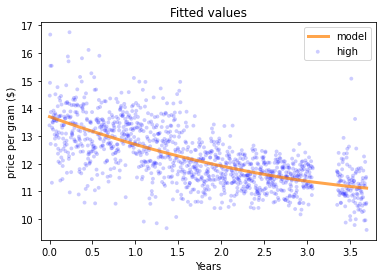

In [10]:
# Solution

PlotFittedValues(model, results, label=name)
thinkplot.Config(title='Fitted values',
                 xlabel='Years',
                 xlim=[-0.1, 3.8],
                 ylabel='price per gram ($)')

To visualize predictions, I show a darker region that quantifies modeling uncertainty and a lighter region that quantifies predictive uncertainty.

In [11]:
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

In [12]:
def SimulateResults(daily, iters=101, func=RunLinearModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

In [13]:
def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

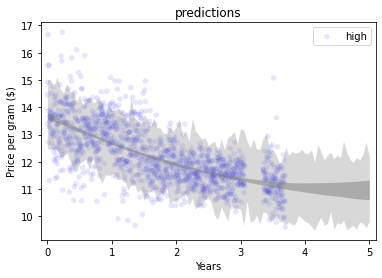

In [14]:
# Solution

years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(title='predictions',
                 xlabel='Years',
                 xlim=[years[0]-0.1, years[-1]+0.1],
                 ylabel='Price per gram ($)')

**Exercise:** Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [15]:
# Solution

class SerialCorrelationTest(thinkstats2.HypothesisTest):
    """Tests serial correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

The following function computes serial correlation with the given lag.

In [16]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [17]:
# Solution

# test the correlation between consecutive prices

name = 'high'
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.4852293761947382 0.0


In [18]:
# Solution

# test for serial correlation in residuals of the linear model

_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)    

0.07570473767506267 0.009


In [19]:
# Solution

# test for serial correlation in residuals of the quadratic model

_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.05607308161289925 0.042


**Worked example:** There are several ways to extend the EWMA model to generate predictions. One of the simplest is something like this:

1. Compute the EWMA of the time series and use the last point as an intercept, `inter`.

2. Compute the EWMA of differences between successive elements in the time series and use the last point as a slope, `slope`.

3. To predict values at future times, compute `inter + slope * dt`, where `dt` is the difference between the time of the prediction and the time of the last observation.
